In [1]:
%%capture
import warnings
import math
import pickle
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm
import re
warnings.filterwarnings('ignore')
try:
    %load_ext autotime
    %load_ext jupyterlab_notify
except:
    !pip3 install ipython-autotime
    %load_ext autotime


time: 1.19 s (started: 2023-02-19 15:25:56 -05:00)


In [2]:
df = pd.read_csv('modern_matches2.csv')
# df = df[['home_ml', 'away_ml', 'over', 'under',
#         'spread', 'home_spread', 'home_ps_odds', 'away_spread', 'away_ps_odds', 
#         'movl', 'h_win', 'playoff_game', 'past_3_home_favorite_wins', 
#          'past_3_away_favorite_wins', 'season', 'home_implied']]
df['vig'] = 1/df['home_ml'] + 1/df['away_ml'] 
df = df.drop(['favorite_won'],axis=1)
df=df.dropna(subset=['home_ml','away_ml'])

time: 389 ms (started: 2023-02-19 15:25:57 -05:00)


In [3]:
from collections import defaultdict

favorite_df = defaultdict(list)
p = re.compile('prev.*ema')

features = ['season', 'home_implied', 
            'home_win', 'home_ml', 'away_ml',
            #'prev_home_elo', 'prev_away_elo',
            #'spread', 'home_spread',
            'past_5_home_win_ratio', 'past_5_away_win_ratio',
            ] 
columns = df.columns

ema_features = [c for c in columns if p.match(c)]

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    # home team is the favorite
    
    favorite_won = False
    
    if row['home_ml'] < row['away_ml']:
        favorite_df['favorite_ml'].append(row['home_ml'])
        favorite_df['underdog_ml'].append(row['away_ml'])
        favorite_df['favorite_is_home'].append(1)
        favorite_df['recent_favorite_win_ratio_5'].append(row['past_5_home_win_ratio'])
        favorite_df['recent_underdog_win_ratio_5'].append(row['past_5_away_win_ratio'])  
        favorite_df['recent_favorite_win_ratio_4'].append(row['past_4_home_win_ratio'])
        favorite_df['recent_underdog_win_ratio_4'].append(row['past_4_away_win_ratio'])           
        favorite_df['recent_favorite_win_ratio_3'].append(row['past_3_home_win_ratio'])
        favorite_df['recent_underdog_win_ratio_3'].append(row['past_3_away_win_ratio'])
        if row['home_win']:
            favorite_won = True
    else:
        if not row['home_win']:
            favorite_won = True
        favorite_df['favorite_ml'].append(row['away_ml'])
        favorite_df['underdog_ml'].append(row['home_ml'])

        favorite_df['favorite_is_home'].append(0)
        favorite_df['recent_favorite_win_ratio_5'].append(row['past_5_away_win_ratio']) 
        favorite_df['recent_underdog_win_ratio_5'].append(row['past_5_home_win_ratio'])
        favorite_df['recent_favorite_win_ratio_4'].append(row['past_4_away_win_ratio']) 
        favorite_df['recent_underdog_win_ratio_4'].append(row['past_4_home_win_ratio'])
        favorite_df['recent_favorite_win_ratio_3'].append(row['past_3_away_win_ratio']) 
        favorite_df['recent_underdog_win_ratio_3'].append(row['past_3_home_win_ratio'])

    favorite_df['favorite_won'].append(1 if favorite_won else 0)
    favorite_df['point_spread'].append(abs(row['home_spread']))


favorite_df = pd.DataFrame(favorite_df)
favorite_df = pd.concat([df.reset_index(drop=True),
                      favorite_df.reset_index(drop=True)],axis=1)
favorite_df['vig'] = 1/favorite_df['favorite_ml'] + 1/favorite_df['underdog_ml'] - 1
favorite_df['favorite_implied'] = 1/favorite_df['favorite_ml'] - favorite_df['vig']/2
favorite_df['underdog_implied'] = 1/favorite_df['underdog_ml'] - favorite_df['vig']/2

favorite_df.to_csv('processed_nba_data.csv', header=True, index=False)
print(favorite_df[['favorite_ml', 'home_ml', 'away_ml']])

  0%|          | 0/11513 [00:00<?, ?it/s]

       favorite_ml   home_ml    away_ml
0         1.099266  1.099266   8.100000
1         1.456783  1.456783   2.830000
2         1.171482  5.400000   1.171482
3         1.103647  1.103647   7.890000
4         1.058775  1.058775  11.460000
...            ...       ...        ...
11508     1.495142  1.495142   2.727778
11509     1.658921  1.658921   2.338000
11510     1.638972  1.638972   2.367059
11511     1.605194  1.605194   2.437778
11512     1.574627  1.574627   2.521111

[11513 rows x 3 columns]
time: 3 s (started: 2023-02-19 15:25:57 -05:00)


n_favorites that won 7830
favorite win ratio 0.6801007556675063


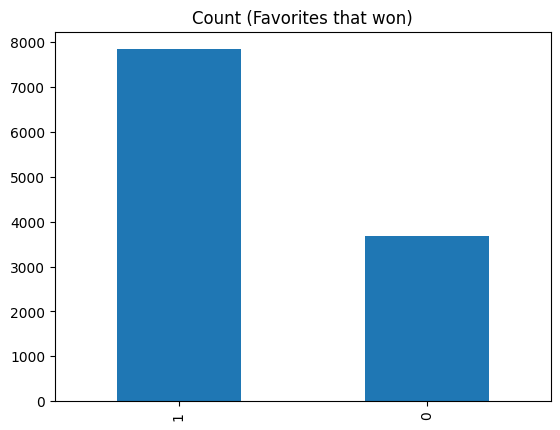

time: 117 ms (started: 2023-02-19 15:26:06 -05:00)


In [4]:
print('n_favorites that won', sum(favorite_df['favorite_won']))
print('favorite win ratio', sum(favorite_df['favorite_won'])/len(favorite_df))
favorite_df.favorite_won.value_counts().plot(kind='bar', title='Count (Favorites that won)');

In [ ]:
from sklearn.decomposition import PCA
X = favorite_df[['favorite_ml','favorite_implied', 'favorite_is_home', 
                'recent_favorite_win_ratio_3','recent_underdog_win_ratio_3',
                'spread', 'point_spread', 'favorite_won']]
X = X.dropna()
y = X['favorite_won']
pca = PCA(n_components=2)
X = pca.fit_transform(X)


# Model 1: Log Reg

In [245]:
import pandas as pd
import numpy as np
import pickle

import warnings
import sys
import re
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from sklearn.metrics import confusion_matrix, f1_score
import imblearn

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

def train_test_split(data):
    cutoff = math.floor(len(data) * 0.8)
    data = data.dropna()

    train = data[data.index < cutoff].copy()
    test = data[data.index >= cutoff].copy()
    # train = data[data.season < 2020].copy()
    # test = data[data.season >= 2020].copy()
    rus = RandomUnderSampler(random_state=42)
    print('Original dataset shape %s' % Counter(train['favorite_won']))
    # train_x, train_y = rus.fit_resample(train, train_y)
    favorite_winners = train[train.favorite_won == 1].index
    sample_size = len(train[train.favorite_won == 0])
    favorite_winners = train[train.favorite_won == 1].index
    underdog_winners = train[train.favorite_won == 0].index

    np.random.seed(42)
    favorite_winners_indices = np.random.choice(favorite_winners, sample_size, replace=False)
    underdog_winners_indices = np.random.choice(underdog_winners, sample_size, replace=False)
    
    
    print(favorite_winners_indices[:5])
    print(underdog_winners_indices[:5])
    all_indices = np.concatenate((favorite_winners_indices,
                                 underdog_winners_indices),
                                 axis=0)
    print(all_indices)
    all_indices = np.sort(all_indices)
    train = train.loc[all_indices]

    print('Resampled dataset shape %s' % Counter(train['favorite_won']))
    return train, test

time: 1.67 ms (started: 2023-02-19 17:06:50 -05:00)


In [250]:
print('n_favorites that won', sum(train_y))
print('favorite win ratio', sum(train_y)/len(train_y))

n_favorites that won 2898
favorite win ratio 0.5
time: 937 µs (started: 2023-02-19 17:06:52 -05:00)


In [251]:
# alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
# l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5
lr = LogisticRegression(random_state=42)
lr.fit(train_x, train_y)

predictions = lr.predict_proba(test_x)
predictions = [i[1] for i in predictions]

predictions = pd.Series(predictions, name='lr_favorite_prob')
pred_df = pd.concat([test_y.reset_index(drop=True), 
                predictions.reset_index(drop=True)], 
            axis=1)

pred_df['lr_pred_favorite'] = pred_df['lr_favorite_prob'].map(lambda x: 0 if x < 0.4 else 1)
pred_df['correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['lr_pred_favorite'] else 0, axis = 1)
acc = pred_df['correct_pred'].sum()/len(pred_df.index)
pred_df.to_csv('lr_predictions.csv', header=True, index=False)
print(f'Accuracy: {acc}')

confusion_mat = confusion_matrix(pred_df['favorite_won'], pred_df['lr_pred_favorite'])
print(confusion_mat)
f1 = f1_score(pred_df['favorite_won'], pred_df['lr_pred_favorite'])
print(f'F1 Score: {f1}')

print(pred_df.head())

importance =lr.coef_[0]

filename = 'lr_model.sav'
pickle.dump(lr, open(filename, 'wb'))

Accuracy: 0.6363636363636364
[[ 316  447]
 [ 409 1182]]
F1 Score: 0.7341614906832299
   favorite_won  lr_favorite_prob  lr_pred_favorite  correct_pred
0             0          0.385127                 0             1
1             1          0.520906                 1             1
2             1          0.637136                 1             1
3             0          0.610700                 1             0
4             1          0.427504                 1             1
time: 58.5 ms (started: 2023-02-19 17:06:53 -05:00)


# Model 1: Bookie Prediction (High Recall)

We employ the most basic strategy of using the bookie's prediction to make our bet.
We acknowledge that the bookie's odds are very accurate.
We want a strategy with high recall initially so that we can use it as meta labels in a secondary model.

In [480]:
data = pd.read_csv('processed_nba_data.csv')
data.dropna(inplace=True)
# Undersample to reduce favorite win ratio in training data

threshold = 1/0.68
threshold = 0
print(threshold)

data['bookie_pred'] = data.apply(lambda x: 1 if x['favorite_ml'] > threshold else 0, axis=1)
data['bookie_correct_pred'] = data.apply(lambda x: 1 if x['bookie_pred'] == x['favorite_won'] else 0, axis=1)
train, test = train_test_split(data)

acc = test['bookie_correct_pred'].sum()/len(test.index)
print(f'Accuracy: {acc}')

confusion_mat = confusion_matrix(test['favorite_won'], test['bookie_pred'])
print(confusion_mat)
f1 = f1_score(test['favorite_won'], test['bookie_pred'])
print(f'F1 Score: {f1}')

#print('classes: ', lr.classes_)

0
Original dataset shape Counter({1: 5764, 0: 2659})
[6372 7115 3606 5895 7221]
[5525 6915 8400 2633 3739]
[6372 7115 3606 ... 5123 1815 8855]
Resampled dataset shape Counter({0: 2659, 1: 2659})
Accuracy: 0.6660384470410856
[[   0  886]
 [   0 1767]]
F1 Score: 0.7995475113122172
time: 630 ms (started: 2023-02-21 16:26:23 -05:00)


# Model 2: LR with meta labels

In [470]:
# Feature engineering
data['spread_ps'] = data['spread']*data['point_spread']
data['spread_ps_favorite_implied'] = data['spread']*data['point_spread']*data['favorite_implied']
data['implied_favorite_is_home'] = data['favorite_implied']*(data['favorite_is_home']+0.5)

time: 1.38 ms (started: 2023-02-21 12:40:56 -05:00)


In [471]:
features = ['favorite_won', 'favorite_ml', 'underdog_ml',
            #'spread', 'point_spread', 'favorite_implied',
            'recent_favorite_win_ratio_4', 'recent_underdog_win_ratio_4',
            'favorite_is_home','bookie_pred',
            'spread_ps', 'spread_ps_favorite_implied', 'favorite_implied',
            'implied_favorite_is_home']


data = data[features]
train, test = train_test_split(data)
train_y = train['favorite_won']
test_y = test['favorite_won']
train_x = train.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)
test_x = test.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)

# Scale features
scaler = preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

Original dataset shape Counter({1: 5764, 0: 2659})
[6372 7115 3606 5895 7221]
[5525 6915 8400 2633 3739]
[6372 7115 3606 ... 5123 1815 8855]
Resampled dataset shape Counter({0: 2659, 1: 2659})
time: 19.7 ms (started: 2023-02-21 12:40:57 -05:00)


In [472]:
print(train['bookie_pred'])

84      1
85      1
86      1
95      1
109     1
       ..
8854    1
8855    1
8856    1
8858    1
8859    1
Name: bookie_pred, Length: 5318, dtype: int64
time: 938 µs (started: 2023-02-21 12:40:57 -05:00)


In [514]:
from sklearn.metrics import classification_report

metalabels_lr = LogisticRegression(random_state=42)
metalabels_lr.fit(train_x, train_y)

predictions = metalabels_lr.predict_proba(test_x)
predictions = [i[1] for i in predictions]

predictions = pd.Series(predictions, name='lr_winning_prob')
pred_df = pd.concat([test_y.reset_index(drop=True),
                     test['bookie_pred'].reset_index(drop=True),
                    predictions.reset_index(drop=True),
                    test['favorite_implied'].reset_index(drop=True),
                    test['favorite_ml'].reset_index(drop=True),
                    test['underdog_ml'].reset_index(drop=True)], 
                    axis=1)

pred_df['lr_pred_favorite'] = pred_df['lr_winning_prob'].map(lambda x: 0 if x < 0.5 else 1)

pred_df['final_pred'] = pred_df.apply \
    (lambda x: 1 if x['bookie_pred'] == 1 and x['lr_pred_favorite'] == 1 \
     else 0, axis=1)

## if final_pred = 1: then that means the secondary model predicts that the probability it is correct is
# at least 0.5
# otherwise we bet the underdog
   

pred_df['final_correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['final_pred'] else 0, axis = 1)

pred_df['bookie_correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['bookie_pred'] else 0, axis = 1)
acc = pred_df['final_correct_pred'].sum()/len(pred_df.index)
bookie_acc = pred_df['bookie_correct_pred'].sum()/len(pred_df.index)

pred_df.to_csv('metalabels_lr_predictions.csv', header=True, index=False)

print(f'Bookie Accuracy: {bookie_acc}')
confusion_mat = confusion_matrix(pred_df['favorite_won'], pred_df['bookie_pred'])
print(confusion_mat)
print(classification_report(pred_df['favorite_won'], pred_df['bookie_pred']))
print('----')
print(f'LR Accuracy: {acc}')
confusion_mat = confusion_matrix(pred_df['favorite_won'], pred_df['final_pred'])
print(confusion_mat)
print(classification_report(pred_df['favorite_won'], pred_df['final_pred']))


importance =metalabels_lr.coef_[0]

#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

print(train.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1).columns)
filename = 'metalabels_lr_model.sav'
pickle.dump(metalabels_lr, open(filename, 'wb'))

Bookie Accuracy: 0.6660384470410856
[[   0  886]
 [   0 1767]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       886
           1       0.67      1.00      0.80      1767

    accuracy                           0.67      2653
   macro avg       0.33      0.50      0.40      2653
weighted avg       0.44      0.67      0.53      2653

----
LR Accuracy: 0.5506973237843951
[[599 287]
 [905 862]]
              precision    recall  f1-score   support

           0       0.40      0.68      0.50       886
           1       0.75      0.49      0.59      1767

    accuracy                           0.55      2653
   macro avg       0.57      0.58      0.55      2653
weighted avg       0.63      0.55      0.56      2653

Feature: 0, Score: -0.04715
Feature: 1, Score: 0.05460
Feature: 2, Score: 0.16507
Feature: 3, Score: 0.11228
Feature: 4, Score: -1.00561
Feature: 5, Score: 1.16428
Feature: 6, Score: 0.64429
Feature: 7, Score: -0.22732
Inde

In [515]:
#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(test.columns)
print(test.favorite_implied)

Feature: 0, Score: -0.04715
Feature: 1, Score: 0.05460
Feature: 2, Score: 0.16507
Feature: 3, Score: 0.11228
Feature: 4, Score: -1.00561
Feature: 5, Score: 1.16428
Feature: 6, Score: 0.64429
Feature: 7, Score: -0.22732
Index(['match_id', 'away_id', 'home_id', 'date', 'away_pts', 'home_pts',
       'playoff_game', 'home_ml', 'away_ml', 'home_spread',
       ...
       'recent_favorite_win_ratio_4', 'recent_underdog_win_ratio_4',
       'recent_favorite_win_ratio_3', 'recent_underdog_win_ratio_3',
       'favorite_won', 'point_spread', 'favorite_implied', 'underdog_implied',
       'bookie_pred', 'bookie_correct_pred'],
      dtype='object', length=408)
8860     0.615164
8861     0.575663
8862     0.697242
8863     0.651099
8864     0.548921
           ...   
11508    0.651117
11509    0.587543
11510    0.593837
11511    0.606384
11512    0.619210
Name: favorite_implied, Length: 2653, dtype: float64
time: 910 µs (started: 2023-02-21 16:39:17 -05:00)


<AxesSubplot: >

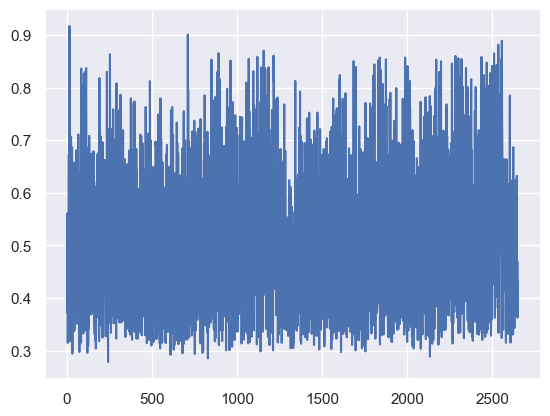

time: 128 ms (started: 2023-02-21 16:39:17 -05:00)


In [516]:
pred_df['lr_winning_prob'].plot()

In [517]:
print(f'n_bet_favorite:', sum(pred_df['final_pred']))
print(f'n_games:', len(pred_df))


n_bet_favorite: 1149
n_games: 2653
time: 377 µs (started: 2023-02-21 16:39:17 -05:00)


# Backtest

In [518]:
# assuming bet probability predictions follow a standard distribution
from statistics import NormalDist
import math
def prob_to_bet_size(p):
    z_score = (p-1/2)/math.sqrt(p*(1-p))
    #'Cumulative distribution function for the standard normal distribution'
    bet_size = 2*NormalDist(mu=0, sigma=1).cdf(z_score)-1
    return bet_size


time: 301 µs (started: 2023-02-21 16:39:17 -05:00)


In [531]:
prob_to_bet_size(2/3)

0.2763263901682369

time: 1.58 ms (started: 2023-02-21 17:06:55 -05:00)


We will bet on the favorite only if they provide a payout higher than 1/0.68 where 0.68 comes from the percentage that favorites win. 


Final Balance: 17.636658146241917


<AxesSubplot: >

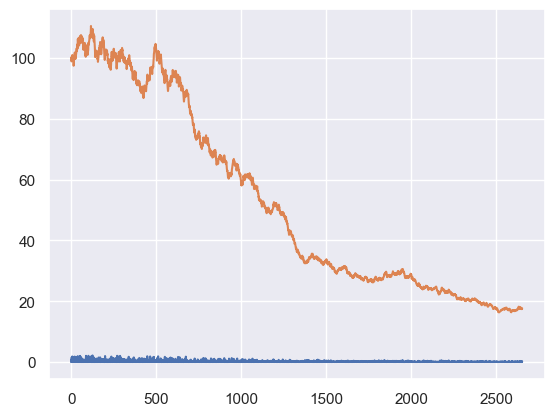

time: 333 ms (started: 2023-02-21 17:22:34 -05:00)


In [557]:
# bet on favorites

def bet_favorite(df):
    balance = 100
    for index, row in df.iterrows():
        
        unit_size = 0.03*balance
        amt_to_win_1_unit = row['favorite_implied']
        bet_size = row['lr_winning_prob'] * unit_size * amt_to_win_1_unit
        
        if (row['final_pred'] == row['favorite_won']) :
            df.at[index, 'bet_won'] = 1
            if row['favorite_won']:
                df.at[index, 'profit'] = bet_size * (row['favorite_ml']-1)
            else:
                df.at[index, 'profit'] = bet_size * (row['underdog_ml']-1)

            balance += df.at[index, 'profit'] 
        else:
            df.at[index, 'bet_won'] = 0
            df.at[index, 'profit'] = 0
            balance -= bet_size
        df.at[index, 'balance'] = balance
    return balance
print('Final Balance:', bet_favorite(pred_df))
pred_df['profit'].plot()
pred_df['balance'].plot()